In [ ]:
seed = 0
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
PATIENCE = 15
EPOCHS = 200
SPLITS_SIZE = 0.2
model_name = "UNET3" # with Deep supervision and Crossentropy loss

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import mixed_precision
import keras_cv
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## Loading the dataset

In [ ]:
data = np.load("/kaggle/input/an2dl-challenge-2/mars_for_students_V1.npz")
training_set = data["training_set"]

# Extracting each individual table of data
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]
X_test = data["test_set"]

cw =compute_class_weight(class_weight="balanced",classes=np.unique(y_train_val),y=y_train_val.flatten())
print(cw)
cw[4] = 50.0
print(cw)
# Display the shapes of our data
print("X_train_val shape: {}".format(X_train_val.shape))
print("y_train_val shape: {}".format(y_train_val.shape))
print("X_test shape: {}".format(X_test.shape))

# Category map to identify each class more easily
category_map = {0:0, # Background
                1:1, # Soil
                2:2, # Bedrock
                3:3, # Sand
                4:4} # Big Rock

[  0.82267692   0.58989142   0.85919097   1.08840749 152.215703  ]
[ 0.82267692  0.58989142  0.85919097  1.08840749 50.        ]
X_train_val shape: (2505, 64, 128)
y_train_val shape: (2505, 64, 128)
X_test shape: (10022, 64, 128)


## SPLIT DATA

In [ ]:
# Split the data into training and validation
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

print("Data splitted!")

Splitting data...
Data splitted!


In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = (X_train[..., np.newaxis])/255
X_test = (X_test[..., np.newaxis])/255
X_val = (X_val[..., np.newaxis])/255

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_val:",X_val.shape,"y_val:",y_val.shape)

Input shape: (64, 128, 1)
Number of classes: 5
X_train: (2004, 64, 128, 1) y_train: (2004, 64, 128) X_val: (501, 64, 128, 1) y_val: (501, 64, 128)


In [ ]:
y_train=tf.one_hot(y_train,depth=5)
y_val=tf.one_hot(y_val,depth=5)

print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_val:",X_val.shape,"y_val:",y_val.shape)

X_train: (2004, 64, 128, 1) y_train: (2004, 64, 128, 5) X_val: (501, 64, 128, 1) y_val: (501, 64, 128, 5)


# MODEL

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def get_unet_model(input_shape=(64, 128, 3), num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, ReLU, Add
)
from tensorflow.keras.models import Model

# A residual bridge layer for the U-Net bottleneck.
def residual_bridge_layer(inputs, filters):


    # Main path
    x = Conv2D(filters, kernel_size=3, padding="same", activation=None)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=3, padding="same", activation=None)(x)
    x = BatchNormalization()(x)

    # Residual connection
    residual = Conv2D(filters, kernel_size=1, padding="same", activation=None)(inputs)
    x = Add()([x, residual])
    x = ReLU()(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)

    p = tfkl.MaxPool2D((2, 2))(x)
    return x, p



def conv_block(x, num_filters, act=True,iter=1):
    for i in range(iter):
        x = tfkl.Conv2D(num_filters, kernel_size=3, padding="same")(x)

        if act == True:
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation("relu")(x)

    return x

# U-Net Model
def unet3_model(input_shape=(64, 128, 1), num_classes=5,deep_sup = True):
    inputs = Input(input_shape)
    print(inputs.shape)
    # Encoder
    skip1, pool1 = encoder_block(inputs, 64)
    print("skip1: ",skip1.shape," pool1: ",pool1.shape)

    skip2, pool2 = encoder_block(pool1, 128)
    print("skip2: ",skip2.shape," pool2: ",pool2.shape)
    #
    skip3, pool3 = encoder_block(pool2, 256)
    print("skip3: ",skip3.shape," pool3: ",pool3.shape)
    print("-----"*10)
    # Bridge with Residual Connection
    bridge = residual_bridge_layer(pool3, 512)
    #bridge = conv_block(pool3, 512)
    #bridge = conv_block(bridge, 512)
    print("bridge: ",bridge.shape)
    print("-----"*10)


    # Decoder 3 -------------------------------------------------------------
    skip1_d3 = tfkl.MaxPool2D((4, 4))(skip1)
    print("Before skip1_d3: ",skip1_d3.shape)
    skip1_d3 = conv_block(skip1_d3, 64)
    print("After skip1_d3: ",skip1_d3.shape,"\n")

    skip2_d3 = tfkl.MaxPool2D((2, 2))(skip2)
    print("Before skip2_d3: ",skip2_d3.shape)
    skip2_d3 = conv_block(skip2_d3, 64)
    print("After skip2_d3: ",skip2_d3.shape,"\n")

    skip3_d3 = conv_block(skip3, 64)
    print("After skip3_d3: ",skip3_d3.shape)

    bridge_d3 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(bridge)
    bridge_d3 = conv_block(bridge_d3, 64)
    print("After bridge_d3: ",bridge_d3.shape)

    decoder3 = tfkl.Concatenate()([skip1_d3,skip2_d3,skip3_d3,bridge_d3])
    decoder3 = conv_block(decoder3, 64*4)
    #decoder3 = decoder_block(bridge_d3, [skip1_d3, skip2_d3, skip3_d3], 64)
    print("decoder3: ",decoder3.shape)
    print("------"*10)

    #Decoder 2 -------------------------------------------------------------
    skip1_d2 = tfkl.MaxPool2D((2, 2))(skip1)
    print("Before skip1_d2: ",skip1_d2.shape)
    skip1_d2 = conv_block(skip1_d2, 64)
    print("After skip1_d2: ",skip1_d2.shape,"\n")

    skip2_d2 = conv_block(skip2, 64)
    print("After skip2_d2: ",skip2_d2.shape)

    bridge_d2 = tfkl.UpSampling2D((4, 4), interpolation="bilinear")(bridge)
    bridge_d2 = conv_block(bridge_d2, 64)
    print("After bridge_d3: ",bridge_d2.shape)

    d3_d2 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(decoder3)
    d3_d2 = conv_block(d3_d2, 64)
    print("After bridge_d3: ",d3_d2.shape)

    #decoder2 = decoder_block(decoder3, [skip1_d2,skip2_d2], 64)
    decoder2 = tfkl.Concatenate()([skip1_d2,skip2_d2,bridge_d2,d3_d2])
    decoder2 = conv_block(decoder2, 64*4)
    print("decoder2: ",decoder2.shape)
    print("-----"*10)

    #Decoder 1
    skip1_d1 = conv_block(skip1, 64)
    print("After skip1_d3: ",skip1_d1.shape)

    bridge_d1 = tfkl.UpSampling2D((8, 8), interpolation="bilinear")(bridge)
    bridge_d1 = conv_block(bridge_d1, 64)
    print("After bridge_d1: ",bridge_d1.shape)

    d3_d1 = tfkl.UpSampling2D((4, 4), interpolation="bilinear")(decoder3)
    d3_d1 = conv_block(d3_d1, 64)
    print("After bridge_d3: ",d3_d1.shape)

    d2_d1 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(decoder2)
    d2_d1 = conv_block(d2_d1, 64)
    print("After d3_d2: ",d2_d1.shape)

    #decoder1 = decoder_block(decoder2, [skip1_d3], 64)
    decoder1 = tfkl.Concatenate()([skip1_d1,bridge_d1,d3_d1,d2_d1])
    decoder1 = conv_block(decoder1, 64*4)
    print("decoder1: ",decoder1.shape)
    print("-----"*10)

    # Output layer
    # Deep supervision
    if deep_sup == True:
        y1 = tfkl.Conv2D(num_classes, kernel_size=3, padding="same")(decoder1)
        y1 = tfkl.Activation("sigmoid")(y1)

        y2 = tfkl.Conv2D(num_classes, kernel_size=3, padding="same")(decoder2)
        y2 = tfkl.UpSampling2D((2, 2), interpolation="bilinear")(y2)
        y2 = tfkl.Activation("sigmoid")(y2)

        y3 = tfkl.Conv2D(num_classes, kernel_size=1, padding="same")(decoder3)
        y3 = tfkl.UpSampling2D((4, 4), interpolation="bilinear")(y3)
        y3 = tfkl.Activation("sigmoid")(y3)

        y4 = tfkl.Conv2D(num_classes, kernel_size=1, padding="same")(bridge)
        y4 = tfkl.UpSampling2D((8, 8), interpolation="bilinear")(y4)
        y4 = tfkl.Activation("sigmoid")(y4)

        outputs = [y1, y2, y3, y4]
        def aggregate_outputs(outputs):
            stacked_outputs = tf.stack(outputs, axis=-1)  # Shape: (batch_size, height, width, num_classes, 4)
            aggregated_probs = tf.reduce_mean(stacked_outputs, axis=-1)  # Shape: (batch_size, height, width, num_classes)
            final_predictions = tf.argmax(aggregated_probs, axis=-1)  # Shape: (batch_size, height, width)
            return final_predictions
        outputs = aggregate_outputs(outputs)

    else:

        y1 = tfkl.Conv2D(num_classes, kernel_size=3, padding="same")(decoder1)
        y1 = tfkl.Activation("sigmoid")(y1)
        outputs = [y1]

    # Model
    model = Model(inputs, outputs, name="U-Net_with_Residual_Bridge")
    return model

In [ ]:
if model_name == 'UNET_EXERCISE':
    model = get_unet_model(input_shape=input_shape, num_classes=5)
if model_name == 'UNET3':
    model = unet3_model(input_shape=input_shape, num_classes=num_classes,deep_sup=False)
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)
#model.summary()

(None, 64, 128, 1)
skip1:  (None, 64, 128, 64)  pool1:  (None, 32, 64, 64)
skip2:  (None, 32, 64, 128)  pool2:  (None, 16, 32, 128)
skip3:  (None, 16, 32, 256)  pool3:  (None, 8, 16, 256)
--------------------------------------------------
bridge:  (None, 8, 16, 512)
--------------------------------------------------
Before skip1_d3:  (None, 16, 32, 64)
After skip1_d3:  (None, 16, 32, 64) 

Before skip2_d3:  (None, 16, 32, 128)
After skip2_d3:  (None, 16, 32, 64) 

After skip3_d3:  (None, 16, 32, 64)
After bridge_d3:  (None, 16, 32, 64)
decoder3:  (None, 16, 32, 256)
------------------------------------------------------------
Before skip1_d2:  (None, 32, 64, 64)
After skip1_d2:  (None, 32, 64, 64) 

After skip2_d2:  (None, 32, 64, 64)
After bridge_d3:  (None, 32, 64, 64)
After bridge_d3:  (None, 32, 64, 64)
decoder2:  (None, 32, 64, 256)
--------------------------------------------------
After skip1_d3:  (None, 64, 128, 64)
After bridge_d1:  (None, 64, 128, 64)
After bridge_d3:  (None,

In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # Ensure y_true is one-hot encoded if not already
        if len(y_true.shape) != len(y_pred.shape):
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Compute the focal loss scaling factor
        scaling_factor = tf.pow(1 - y_pred, gamma)

        # Apply the focal loss formula
        focal_loss = alpha * scaling_factor * ce_loss

        # Reduce the loss across spatial and class dimensions
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return loss

In [ ]:
FocalLoss = focal_loss(alpha=0.25, gamma=2.0)


# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
              loss=FocalLoss,
              metrics=['accuracy',
                       tf.keras.metrics.OneHotMeanIoU(
                            num_classes=5,
                            name=None,
                            dtype=None,
                            ignore_class=0,
                            sparse_y_pred=False,
                            axis=-1),
                        tf.keras.losses.Dice(reduction='sum_over_batch_size', name='dice')])
print("Model compiled!")

Model compiled!


In [ ]:
def apply_category_mapping(label):
    # Apply category mapping to labels.
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    # Apply the colormap to a label.
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5, NUM_CLASSES=5):
        super().__init__()
        self.image = tf.expand_dims(image, 0)
        self.label = np.argmax(label, axis=-1)
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            self.label = apply_category_mapping(self.label)
            pred = self.model.predict(self.image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_one_hot_mean_io_u',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback1 = VizCallback(X_val[180], y_val[180])
viz_callback2 = VizCallback(X_val[211], y_val[211])

Epoch 1/200


I0000 00:00:1733437766.423051      96 service.cc:145] XLA service 0x786210002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733437766.423112      96 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733437766.423116      96 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733437826.011584      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3728 - dice: 0.6041 - loss: 0.7321 - one_hot_mean_io_u: 0.1841   

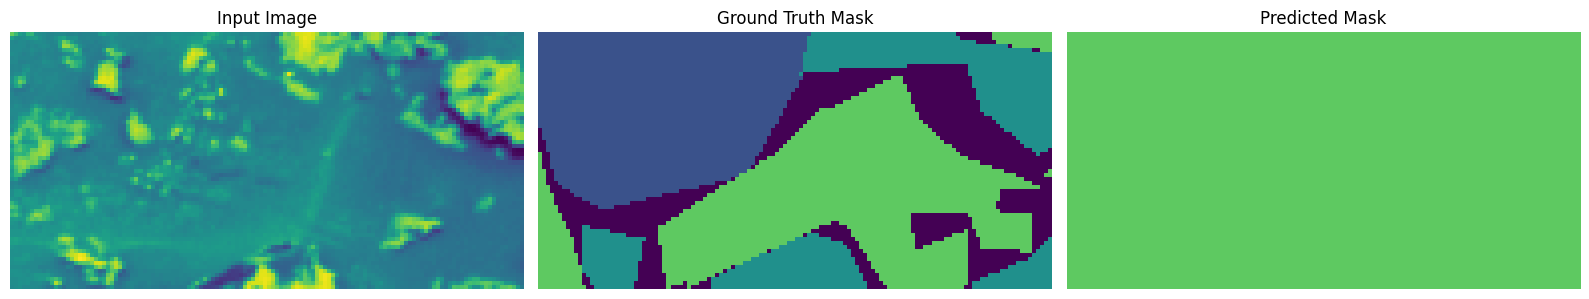

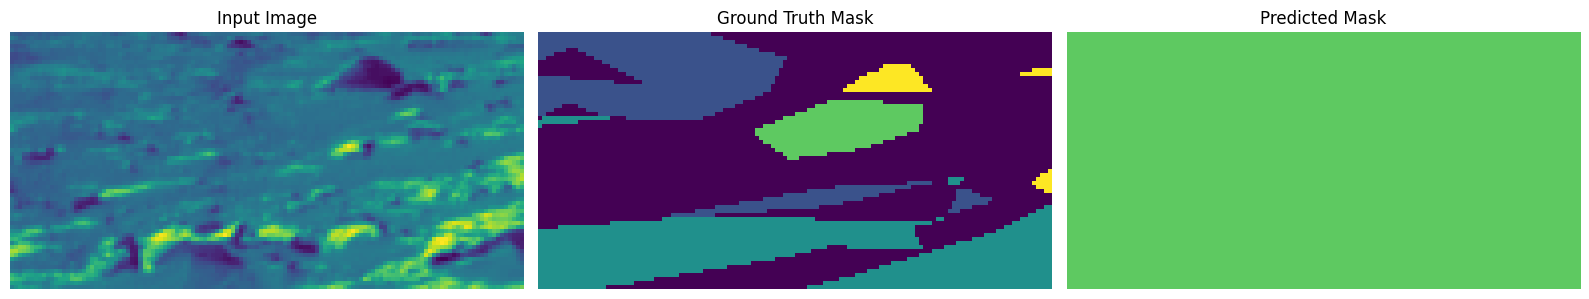

63/63 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.3730 - dice: 0.6039 - loss: 0.7317 - one_hot_mean_io_u: 0.1842 - val_accuracy: 0.1643 - val_dice: 0.7524 - val_loss: 2.6328 - val_one_hot_mean_io_u: 0.0537
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step - accuracy: 0.4308 - dice: 0.5799 - loss: 0.6269 - one_hot_mean_io_u: 0.2144 - val_accuracy: 0.1643 - val_dice: 0.7413 - val_loss: 1.7453 - val_one_hot_mean_io_u: 0.0537
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.5221 - dice: 0.5513 - loss: 0.5705 - one_hot_mean_io_u: 0.2655 - val_accuracy: 0.1643 - val_dice: 0.8041 - val_loss: 3.2730 - val_one_hot_mean_io_u: 0.0537
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 716ms/step - accuracy: 0.5651 - dice: 0.5229 - loss: 0.5302 - one_hot_mean_io_u: 0.3005 - val_accuracy: 0.1643 - val_dice: 0.7833 - val_loss: 2.1254 - val_one_hot_mean_io_u: 0.0537
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 728ms/step - accuracy: 0.5688 - dice: 0.5185 - loss: 0.5062 - one_hot_mean_

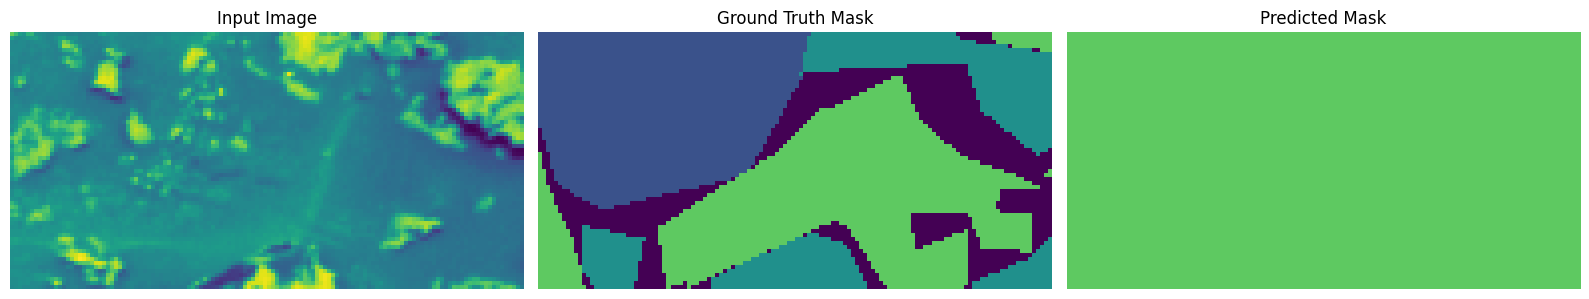

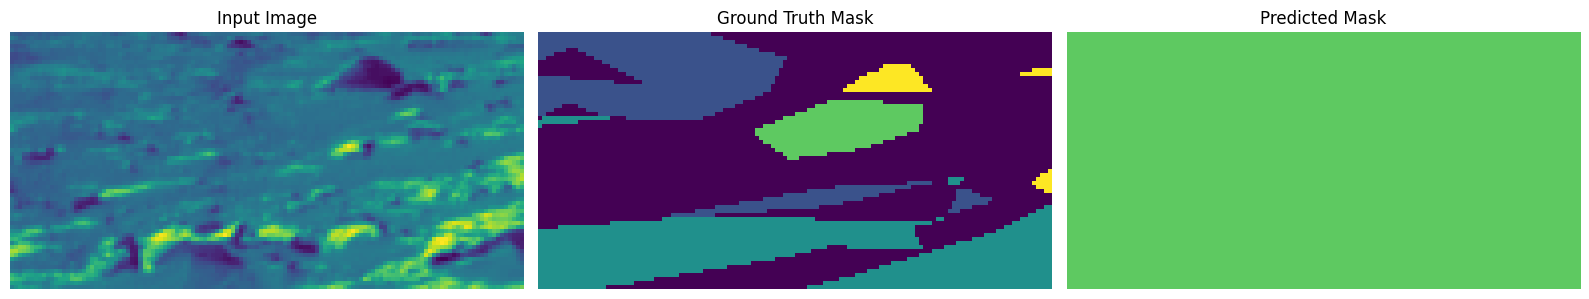

63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 747ms/step - accuracy: 0.5795 - dice: 0.5055 - loss: 0.4862 - one_hot_mean_io_u: 0.3354 - val_accuracy: 0.1643 - val_dice: 0.7764 - val_loss: 2.4899 - val_one_hot_mean_io_u: 0.0430
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 741ms/step - accuracy: 0.6055 - dice: 0.4941 - loss: 0.4647 - one_hot_mean_io_u: 0.3577 - val_accuracy: 0.1750 - val_dice: 0.7550 - val_loss: 2.2144 - val_one_hot_mean_io_u: 0.0492
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 751ms/step - accuracy: 0.6050 - dice: 0.4902 - loss: 0.4513 - one_hot_mean_io_u: 0.3612 - val_accuracy: 0.1850 - val_dice: 0.7241 - val_loss: 2.1394 - val_one_hot_mean_io_u: 0.0565
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 754ms/step - accuracy: 0.6171 - dice: 0.4845 - loss: 0.4346 - one_hot_mean_io_u: 0.3711 - val_accuracy: 0.2632 - val_dice: 0.6581 - val_loss: 1.4744 - val_one_hot_mean_io_u: 0.0966
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.6297 - dice: 0.4694 - loss: 0.4139 - one_hot_me

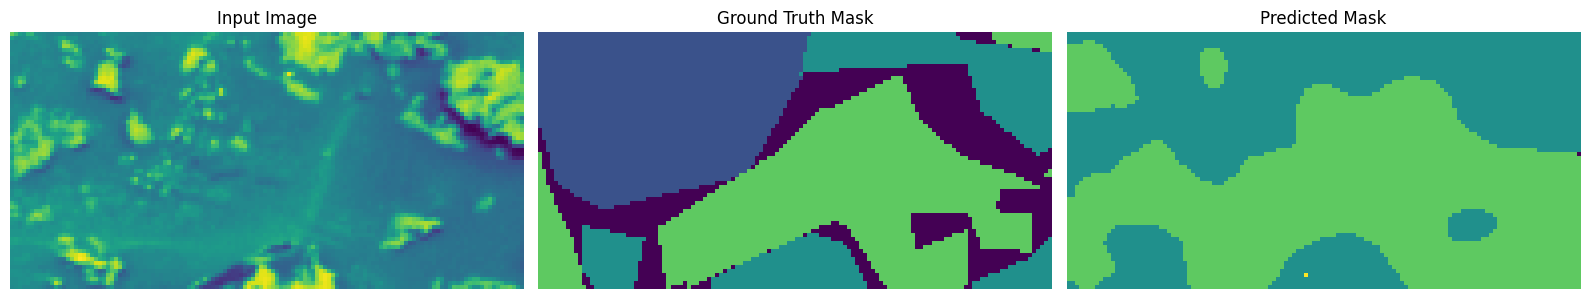

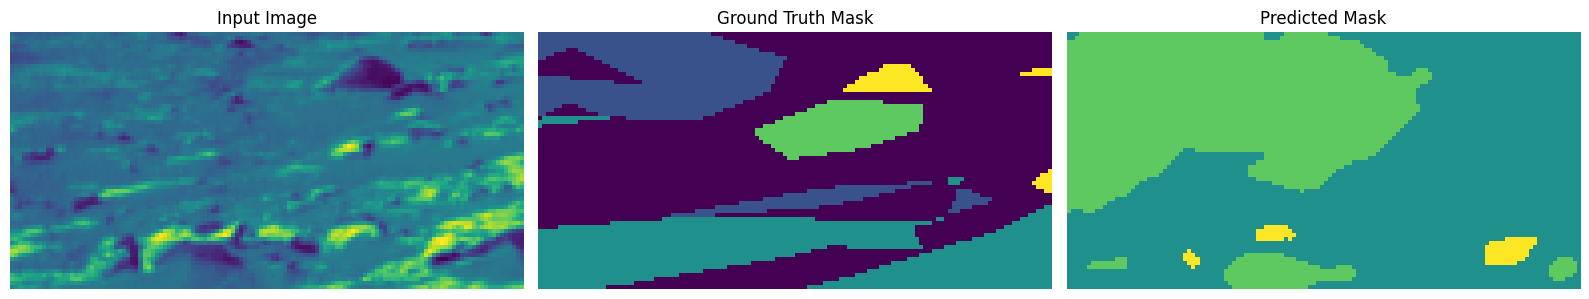

63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 770ms/step - accuracy: 0.6406 - dice: 0.4603 - loss: 0.4139 - one_hot_mean_io_u: 0.3888 - val_accuracy: 0.4398 - val_dice: 0.5811 - val_loss: 0.6846 - val_one_hot_mean_io_u: 0.2362
Epoch 12/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.6102 - dice: 0.4943 - loss: 0.4518 - one_hot_mean_io_u: 0.3570 - val_accuracy: 0.4669 - val_dice: 0.5379 - val_loss: 0.7275 - val_one_hot_mean_io_u: 0.2207
Epoch 13/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.6398 - dice: 0.4656 - loss: 0.4067 - one_hot_mean_io_u: 0.3833 - val_accuracy: 0.3954 - val_dice: 0.5794 - val_loss: 0.8956 - val_one_hot_mean_io_u: 0.1876
Epoch 14/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.6409 - dice: 0.4613 - loss: 0.3999 - one_hot_mean_io_u: 0.3868 - val_accuracy: 0.2830 - val_dice: 0.7093 - val_loss: 2.0487 - val_one_hot_mean_io_u: 0.0669
Epoch 15/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.6285 - dice: 0.4754 - loss: 0.4136 - one_hot

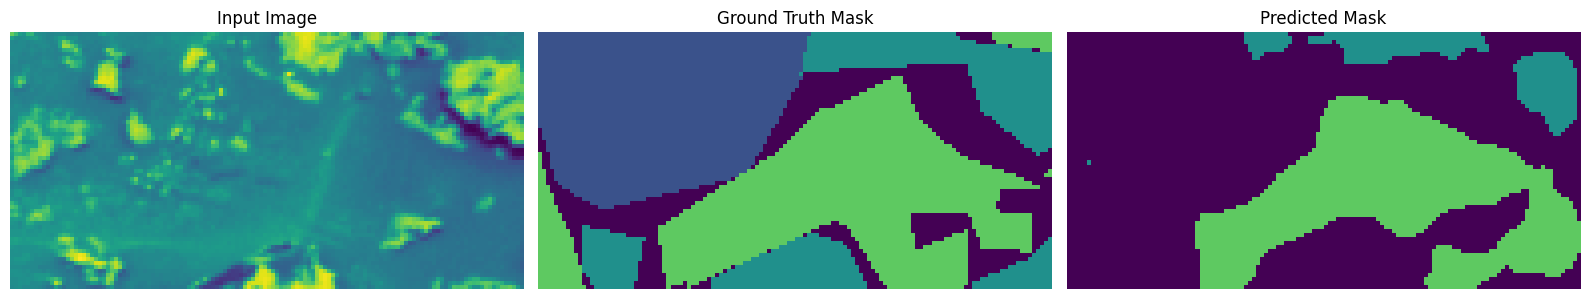

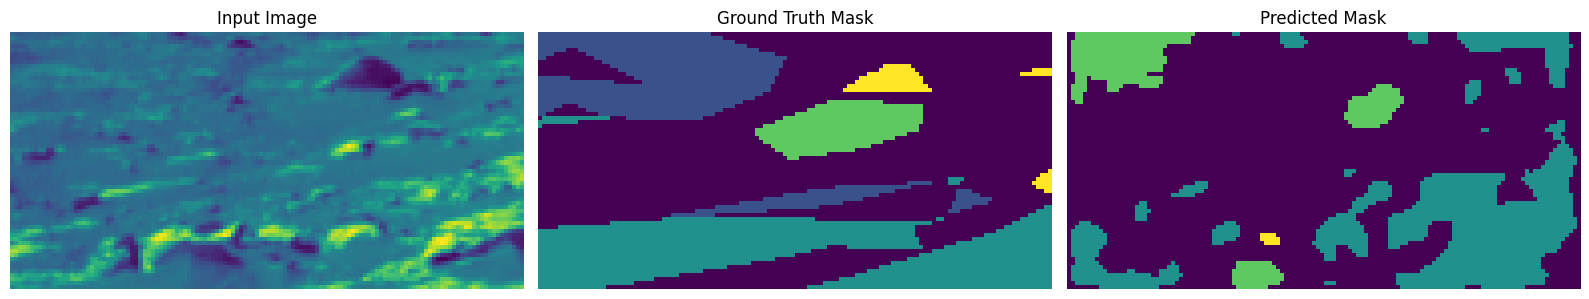

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 777ms/step - accuracy: 0.6590 - dice: 0.4477 - loss: 0.3721 - one_hot_mean_io_u: 0.4009 - val_accuracy: 0.4884 - val_dice: 0.5224 - val_loss: 0.6363 - val_one_hot_mean_io_u: 0.2547
Epoch 17/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.6642 - dice: 0.4396 - loss: 0.3593 - one_hot_mean_io_u: 0.4071 - val_accuracy: 0.5815 - val_dice: 0.4749 - val_loss: 0.6307 - val_one_hot_mean_io_u: 0.3247
Epoch 18/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.6776 - dice: 0.4245 - loss: 0.3331 - one_hot_mean_io_u: 0.4186 - val_accuracy: 0.5968 - val_dice: 0.4683 - val_loss: 0.7009 - val_one_hot_mean_io_u: 0.3417
Epoch 19/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.6819 - dice: 0.4214 - loss: 0.3229 - one_hot_mean_io_u: 0.4236 - val_accuracy: 0.5291 - val_dice: 0.5081 - val_loss: 0.7779 - val_one_hot_mean_io_u: 0.2647
Epoch 20/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.6845 - dice: 0.4236 - loss: 0.3316 - one_hot

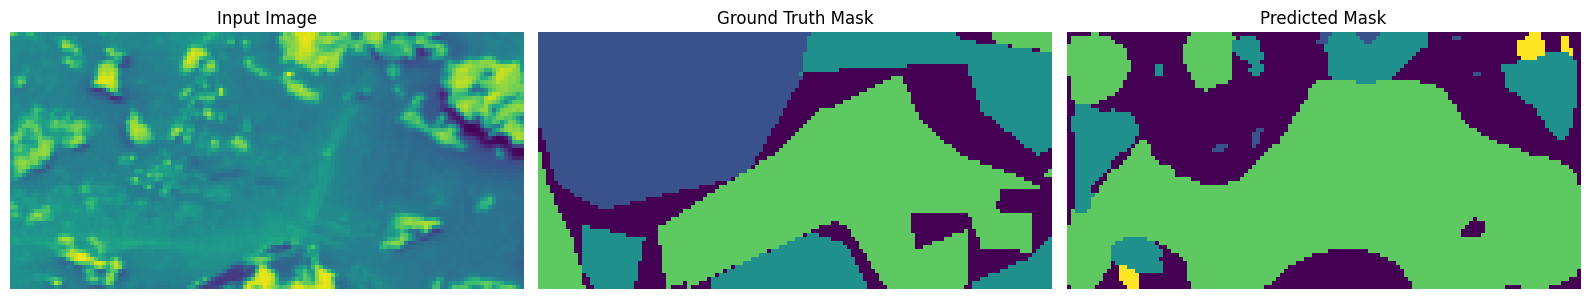

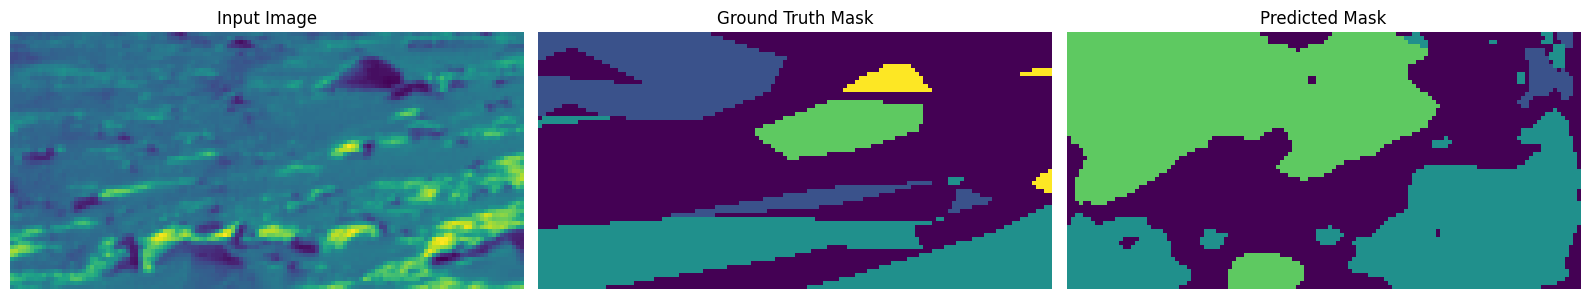

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - accuracy: 0.6835 - dice: 0.4188 - loss: 0.3234 - one_hot_mean_io_u: 0.4272 - val_accuracy: 0.5367 - val_dice: 0.4945 - val_loss: 0.8110 - val_one_hot_mean_io_u: 0.2669
Epoch 22/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.6927 - dice: 0.4111 - loss: 0.3029 - one_hot_mean_io_u: 0.4347 - val_accuracy: 0.5675 - val_dice: 0.4969 - val_loss: 0.6278 - val_one_hot_mean_io_u: 0.3263
Epoch 23/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.6970 - dice: 0.4113 - loss: 0.2963 - one_hot_mean_io_u: 0.4435 - val_accuracy: 0.6191 - val_dice: 0.4462 - val_loss: 0.6245 - val_one_hot_mean_io_u: 0.3394
Epoch 24/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.7117 - dice: 0.3946 - loss: 0.2748 - one_hot_mean_io_u: 0.4586 - val_accuracy: 0.6130 - val_dice: 0.4476 - val_loss: 0.6359 - val_one_hot_mean_io_u: 0.3491
Epoch 25/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.7053 - dice: 0.4007 - loss: 0.2866 - one_hot

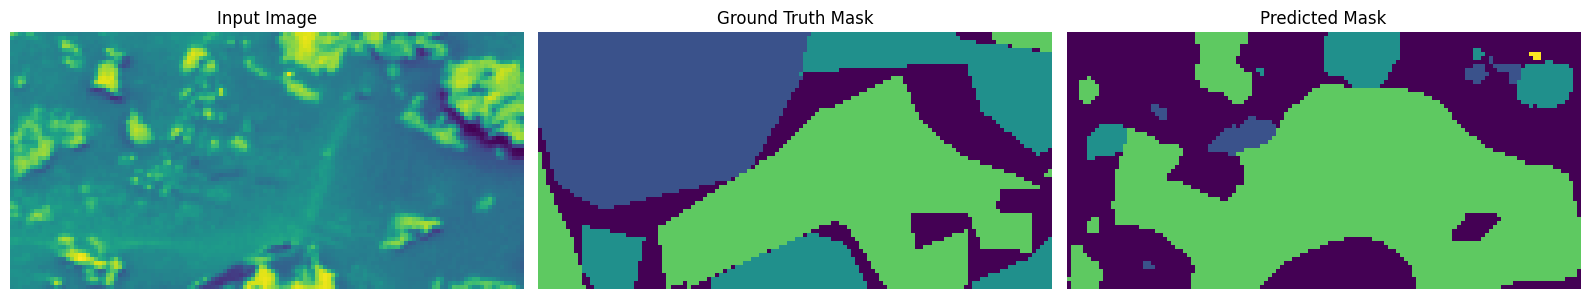

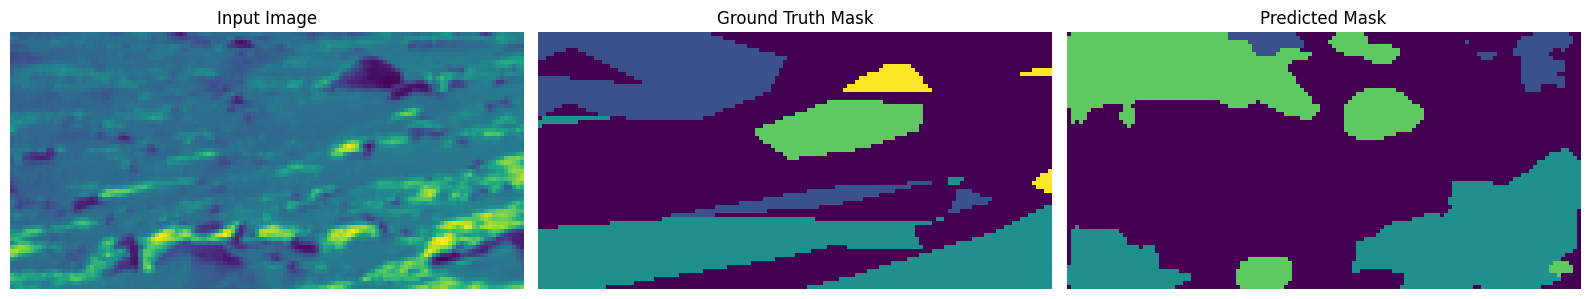

63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 770ms/step - accuracy: 0.6941 - dice: 0.4108 - loss: 0.3067 - one_hot_mean_io_u: 0.4308 - val_accuracy: 0.6089 - val_dice: 0.4468 - val_loss: 0.7638 - val_one_hot_mean_io_u: 0.3288
Epoch 27/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7216 - dice: 0.3872 - loss: 0.2677 - one_hot_mean_io_u: 0.4694 - val_accuracy: 0.6374 - val_dice: 0.4356 - val_loss: 0.7003 - val_one_hot_mean_io_u: 0.3664
Epoch 28/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7311 - dice: 0.3795 - loss: 0.2519 - one_hot_mean_io_u: 0.4840 - val_accuracy: 0.5481 - val_dice: 0.4881 - val_loss: 0.7440 - val_one_hot_mean_io_u: 0.2888
Epoch 29/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.7124 - dice: 0.3928 - loss: 0.2764 - one_hot_mean_io_u: 0.4526 - val_accuracy: 0.6582 - val_dice: 0.4127 - val_loss: 0.8687 - val_one_hot_mean_io_u: 0.3604
Epoch 30/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 765ms/step - accuracy: 0.7238 - dice: 0.3809 - loss: 0.2558 - one_hot

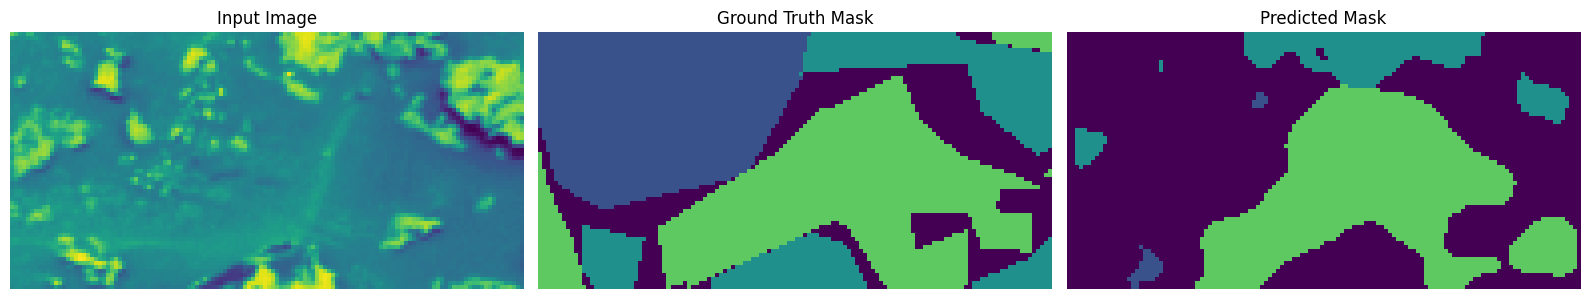

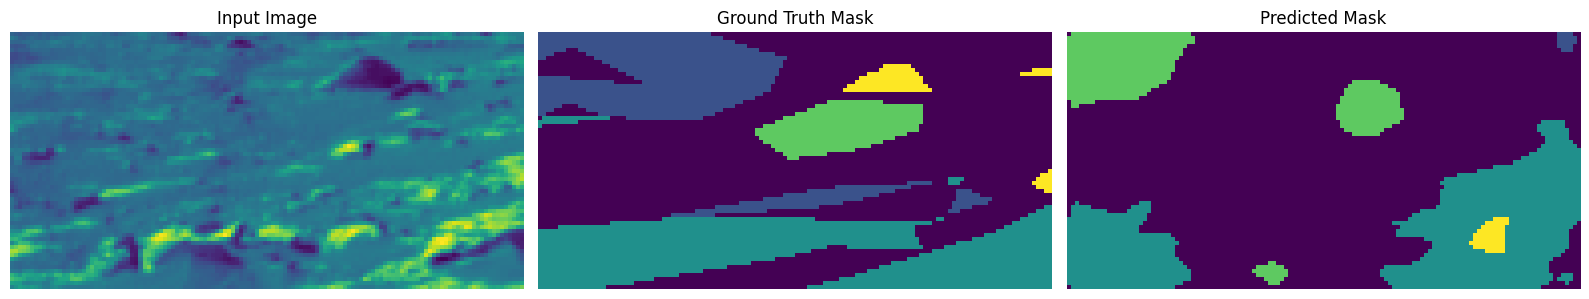

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 775ms/step - accuracy: 0.6714 - dice: 0.4294 - loss: 0.3521 - one_hot_mean_io_u: 0.4026 - val_accuracy: 0.6254 - val_dice: 0.4503 - val_loss: 0.8704 - val_one_hot_mean_io_u: 0.3337
Epoch 32/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 764ms/step - accuracy: 0.6920 - dice: 0.4077 - loss: 0.3098 - one_hot_mean_io_u: 0.4316 - val_accuracy: 0.6529 - val_dice: 0.4125 - val_loss: 0.6920 - val_one_hot_mean_io_u: 0.3799
Epoch 33/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 765ms/step - accuracy: 0.7188 - dice: 0.3843 - loss: 0.2624 - one_hot_mean_io_u: 0.4716 - val_accuracy: 0.6460 - val_dice: 0.4198 - val_loss: 0.6587 - val_one_hot_mean_io_u: 0.3812
Epoch 34/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.7265 - dice: 0.3799 - loss: 0.2494 - one_hot_mean_io_u: 0.4755 - val_accuracy: 0.6193 - val_dice: 0.4605 - val_loss: 0.7598 - val_one_hot_mean_io_u: 0.3413
Epoch 35/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 764ms/step - accuracy: 0.7306 - dice: 0.3736 - loss: 0.2396 - one_hot

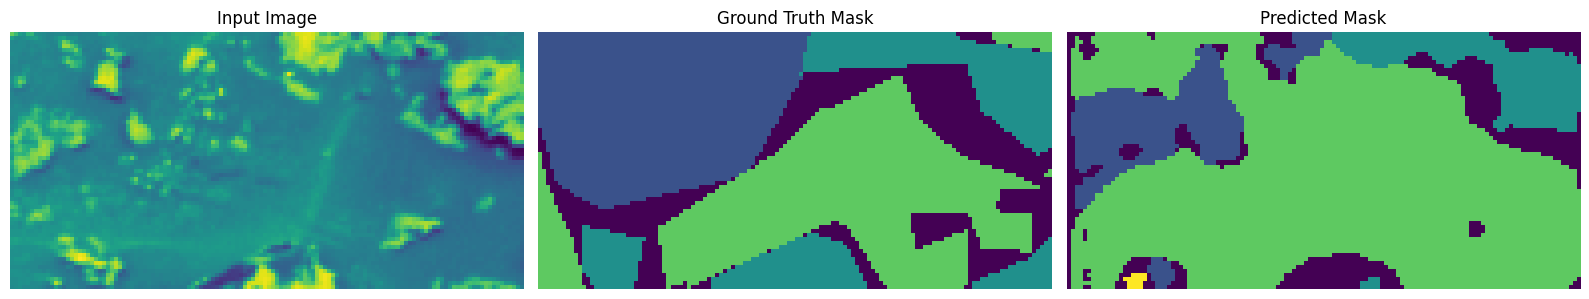

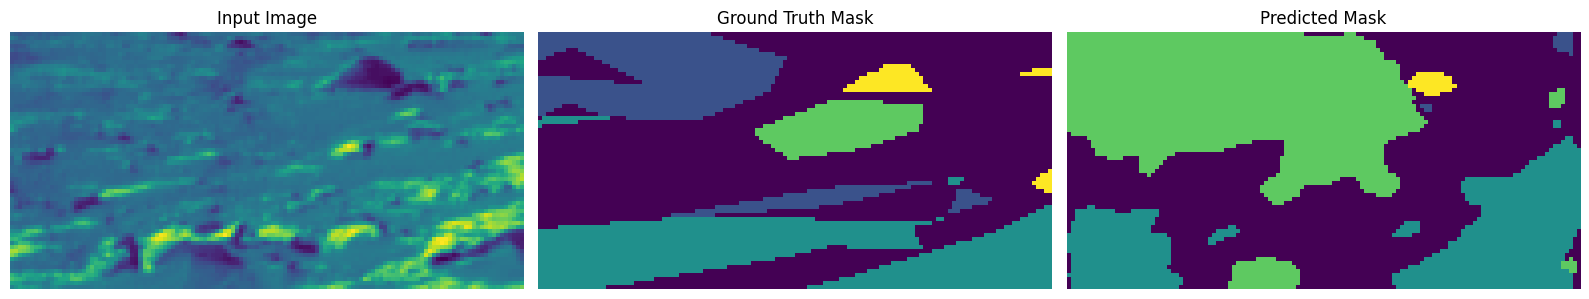

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - accuracy: 0.7485 - dice: 0.3609 - loss: 0.2245 - one_hot_mean_io_u: 0.5070 - val_accuracy: 0.5026 - val_dice: 0.5352 - val_loss: 0.8802 - val_one_hot_mean_io_u: 0.2481
Epoch 37/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.7370 - dice: 0.3691 - loss: 0.2371 - one_hot_mean_io_u: 0.4870 - val_accuracy: 0.6175 - val_dice: 0.4515 - val_loss: 1.0573 - val_one_hot_mean_io_u: 0.3465
Epoch 38/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 764ms/step - accuracy: 0.7437 - dice: 0.3659 - loss: 0.2310 - one_hot_mean_io_u: 0.4933 - val_accuracy: 0.6605 - val_dice: 0.4063 - val_loss: 0.6443 - val_one_hot_mean_io_u: 0.4144
Epoch 39/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.7447 - dice: 0.3617 - loss: 0.2299 - one_hot_mean_io_u: 0.4935 - val_accuracy: 0.6491 - val_dice: 0.4203 - val_loss: 0.7044 - val_one_hot_mean_io_u: 0.3858
Epoch 40/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 768ms/step - accuracy: 0.7523 - dice: 0.3546 - loss: 0.2125 - one_hot

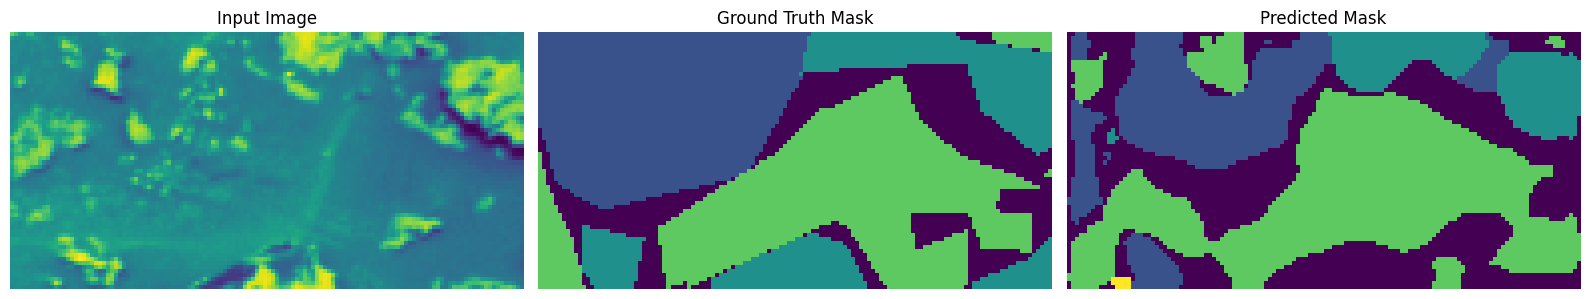

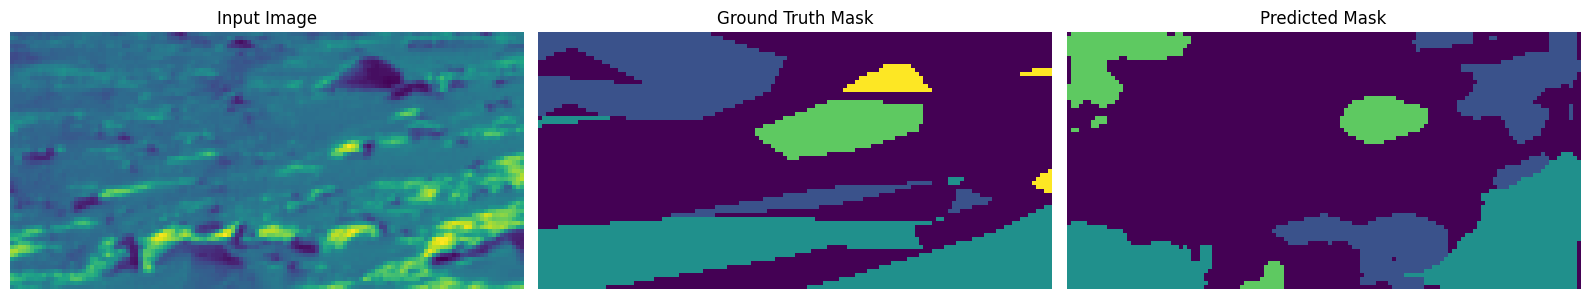

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 771ms/step - accuracy: 0.7659 - dice: 0.3429 - loss: 0.1950 - one_hot_mean_io_u: 0.5556 - val_accuracy: 0.6726 - val_dice: 0.4016 - val_loss: 0.8428 - val_one_hot_mean_io_u: 0.3846
Epoch 42/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7686 - dice: 0.3401 - loss: 0.1908 - one_hot_mean_io_u: 0.5699 - val_accuracy: 0.6426 - val_dice: 0.4225 - val_loss: 0.9211 - val_one_hot_mean_io_u: 0.3667
Epoch 43/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7772 - dice: 0.3347 - loss: 0.1790 - one_hot_mean_io_u: 0.5925 - val_accuracy: 0.5780 - val_dice: 0.4802 - val_loss: 1.0682 - val_one_hot_mean_io_u: 0.3203
Epoch 44/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 764ms/step - accuracy: 0.7801 - dice: 0.3301 - loss: 0.1789 - one_hot_mean_io_u: 0.5876 - val_accuracy: 0.6422 - val_dice: 0.4256 - val_loss: 0.8475 - val_one_hot_mean_io_u: 0.3860
Epoch 45/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 765ms/step - accuracy: 0.7812 - dice: 0.3296 - loss: 0.1800 - one_hot

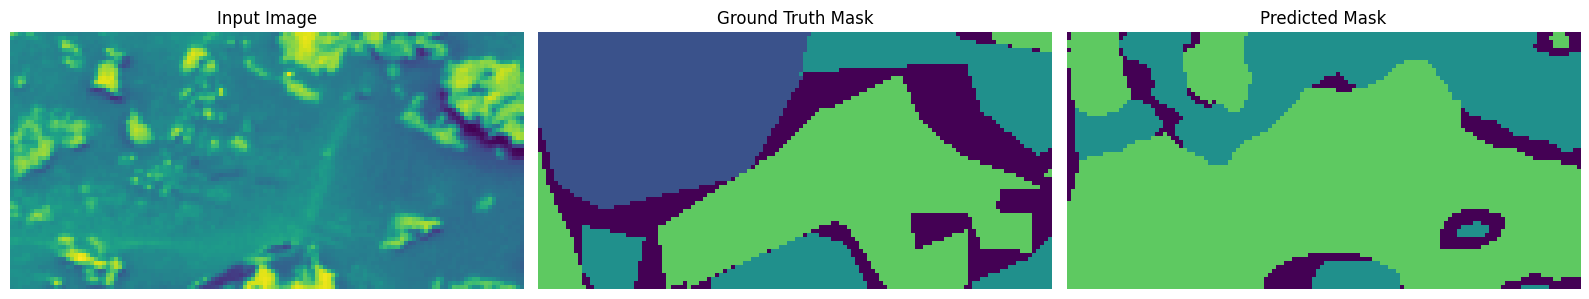

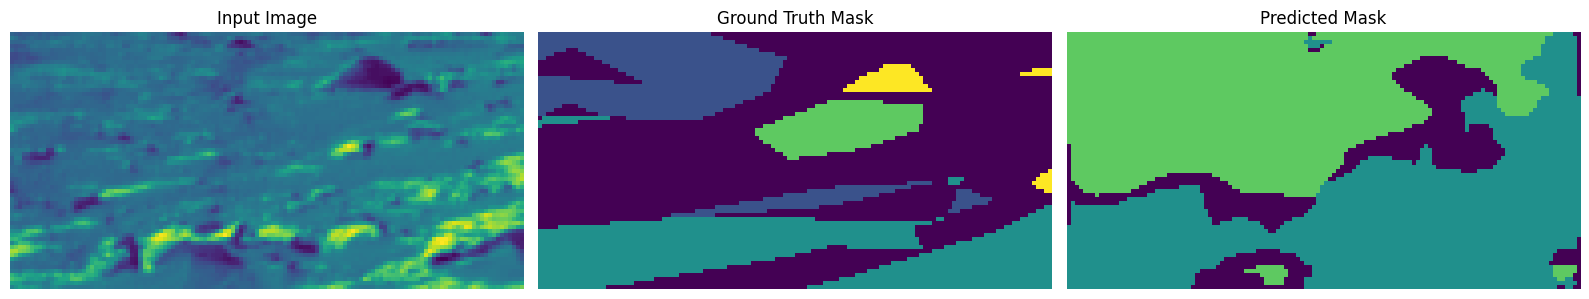

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 774ms/step - accuracy: 0.7776 - dice: 0.3273 - loss: 0.1817 - one_hot_mean_io_u: 0.5823 - val_accuracy: 0.4880 - val_dice: 0.5236 - val_loss: 1.4294 - val_one_hot_mean_io_u: 0.2465
Epoch 47/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7193 - dice: 0.3809 - loss: 0.2744 - one_hot_mean_io_u: 0.4517 - val_accuracy: 0.4199 - val_dice: 0.5195 - val_loss: 1.3986 - val_one_hot_mean_io_u: 0.1765
Epoch 48/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 764ms/step - accuracy: 0.7268 - dice: 0.3764 - loss: 0.2460 - one_hot_mean_io_u: 0.4780 - val_accuracy: 0.7037 - val_dice: 0.3625 - val_loss: 0.7441 - val_one_hot_mean_io_u: 0.4358
Epoch 49/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.7687 - dice: 0.3349 - loss: 0.1888 - one_hot_mean_io_u: 0.5465 - val_accuracy: 0.6798 - val_dice: 0.4066 - val_loss: 0.8083 - val_one_hot_mean_io_u: 0.3994
Epoch 50/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 766ms/step - accuracy: 0.7645 - dice: 0.3397 - loss: 0.2095 - one_hot

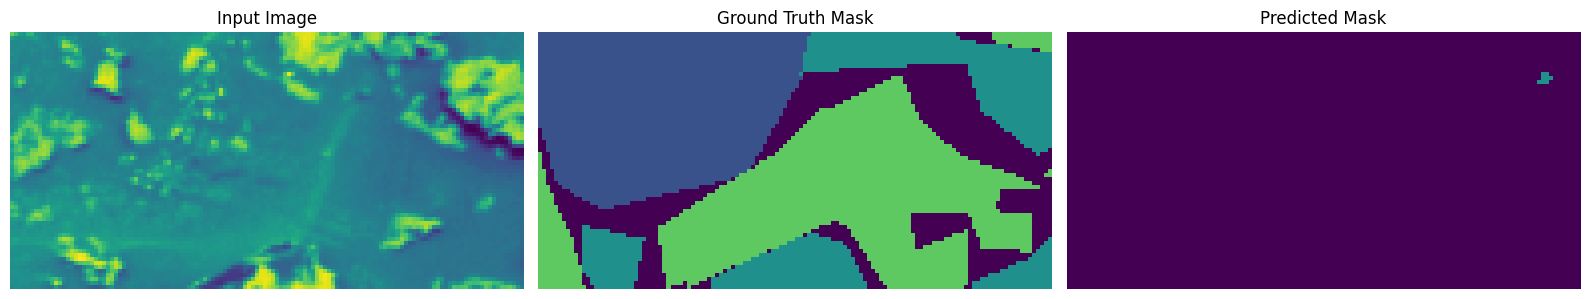

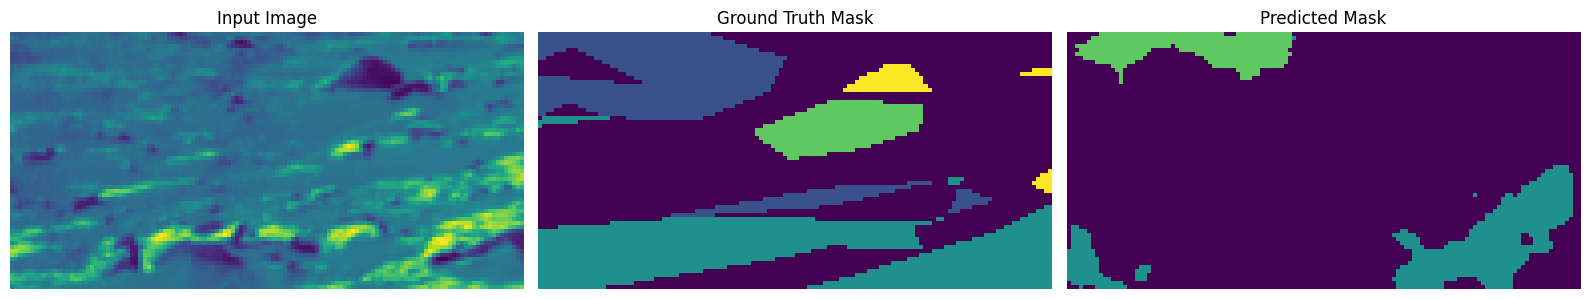

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 772ms/step - accuracy: 0.7635 - dice: 0.3352 - loss: 0.2076 - one_hot_mean_io_u: 0.5079 - val_accuracy: 0.6050 - val_dice: 0.4311 - val_loss: 0.9531 - val_one_hot_mean_io_u: 0.2949
Epoch 52/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7647 - dice: 0.3447 - loss: 0.2003 - one_hot_mean_io_u: 0.5065 - val_accuracy: 0.6903 - val_dice: 0.3990 - val_loss: 0.5882 - val_one_hot_mean_io_u: 0.4283
Epoch 53/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 765ms/step - accuracy: 0.7783 - dice: 0.3223 - loss: 0.1725 - one_hot_mean_io_u: 0.5264 - val_accuracy: 0.7093 - val_dice: 0.3772 - val_loss: 0.5414 - val_one_hot_mean_io_u: 0.4392
Epoch 54/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7906 - dice: 0.3113 - loss: 0.1618 - one_hot_mean_io_u: 0.5722 - val_accuracy: 0.6552 - val_dice: 0.4195 - val_loss: 0.7267 - val_one_hot_mean_io_u: 0.3758
Epoch 55/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.7984 - dice: 0.3025 - loss: 0.1505 - one_hot

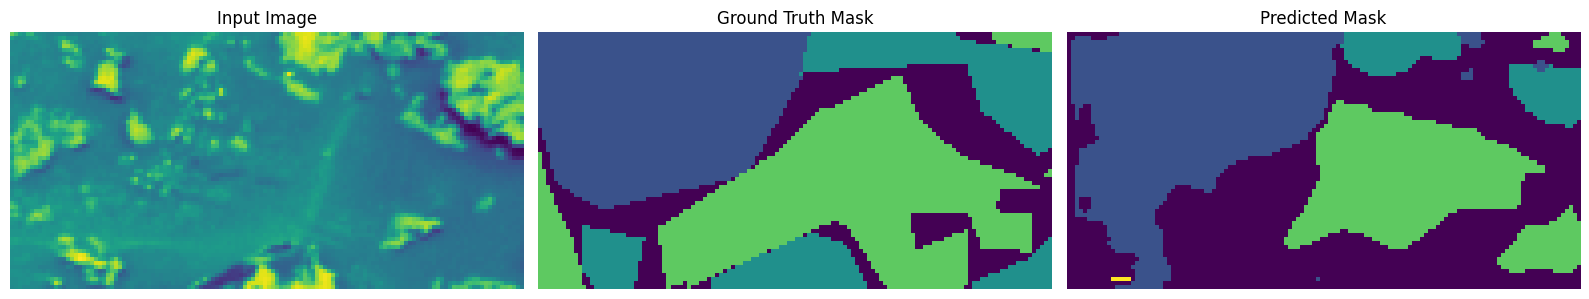

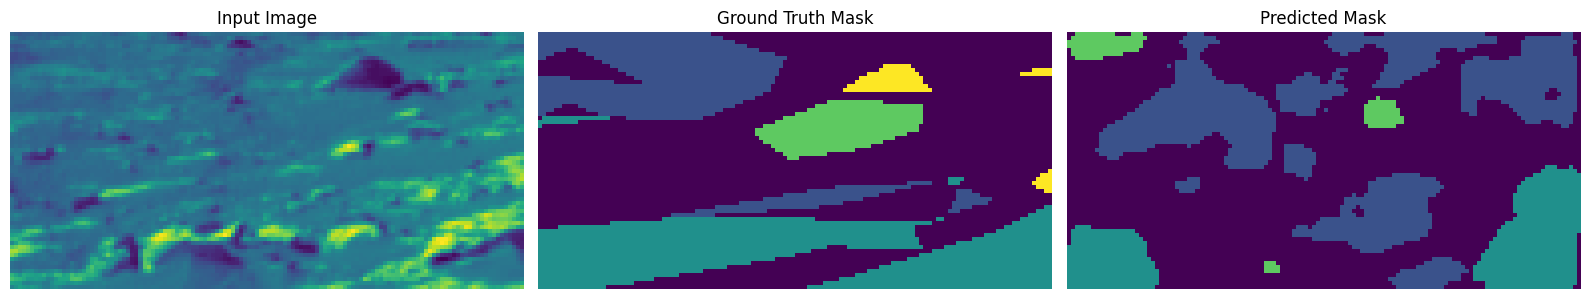

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 772ms/step - accuracy: 0.8082 - dice: 0.2926 - loss: 0.1400 - one_hot_mean_io_u: 0.6161 - val_accuracy: 0.6809 - val_dice: 0.3802 - val_loss: 0.8484 - val_one_hot_mean_io_u: 0.4103
Epoch 57/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8089 - dice: 0.2911 - loss: 0.1372 - one_hot_mean_io_u: 0.6186 - val_accuracy: 0.7054 - val_dice: 0.3538 - val_loss: 0.9363 - val_one_hot_mean_io_u: 0.4304
Epoch 58/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8140 - dice: 0.2871 - loss: 0.1351 - one_hot_mean_io_u: 0.6112 - val_accuracy: 0.5296 - val_dice: 0.4958 - val_loss: 1.5874 - val_one_hot_mean_io_u: 0.2399
Epoch 59/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.7952 - dice: 0.3072 - loss: 0.1599 - one_hot_mean_io_u: 0.5499 - val_accuracy: 0.7121 - val_dice: 0.3596 - val_loss: 0.9651 - val_one_hot_mean_io_u: 0.4287
Epoch 60/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8139 - dice: 0.2886 - loss: 0.1358 - one_hot

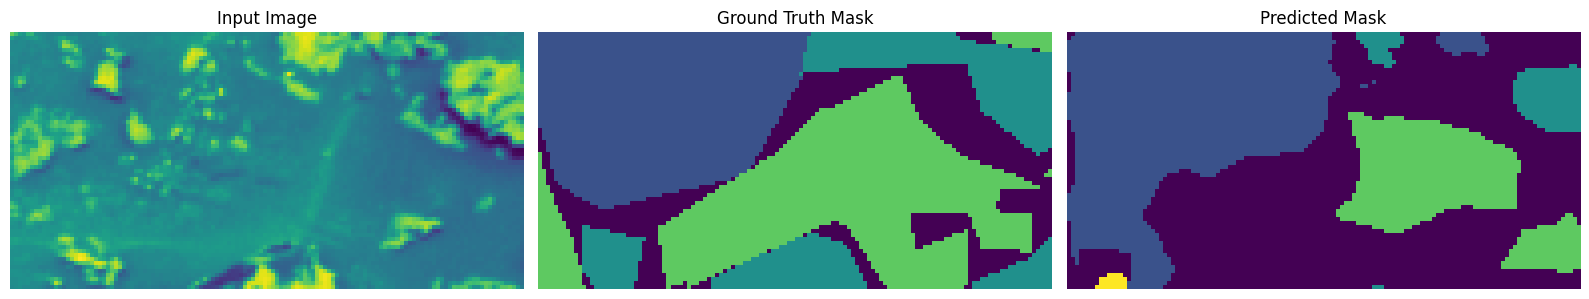

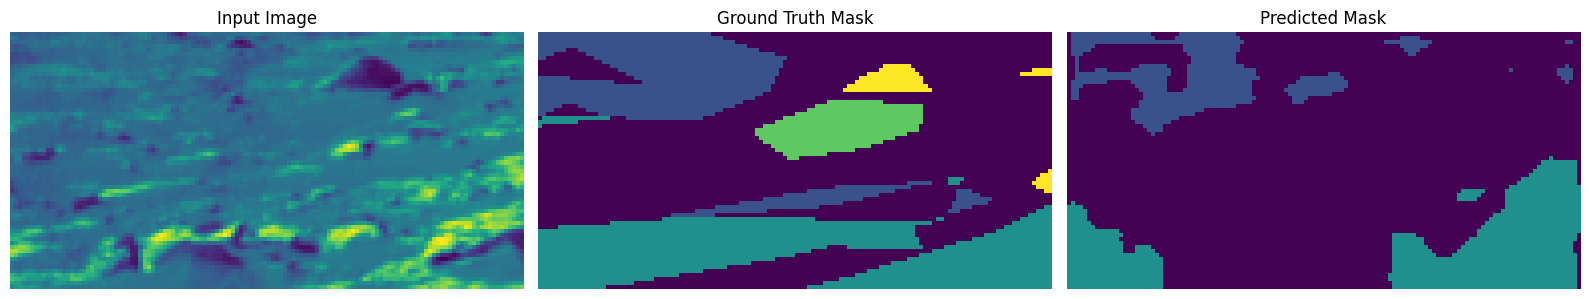

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - accuracy: 0.8240 - dice: 0.2787 - loss: 0.1229 - one_hot_mean_io_u: 0.6361 - val_accuracy: 0.7084 - val_dice: 0.3534 - val_loss: 0.9711 - val_one_hot_mean_io_u: 0.4075
Epoch 62/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.8225 - dice: 0.2765 - loss: 0.1253 - one_hot_mean_io_u: 0.6377 - val_accuracy: 0.7019 - val_dice: 0.3514 - val_loss: 0.9059 - val_one_hot_mean_io_u: 0.4176
Epoch 63/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8390 - dice: 0.2624 - loss: 0.1082 - one_hot_mean_io_u: 0.6693 - val_accuracy: 0.7430 - val_dice: 0.3221 - val_loss: 0.9522 - val_one_hot_mean_io_u: 0.4649
Epoch 64/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8420 - dice: 0.2598 - loss: 0.1055 - one_hot_mean_io_u: 0.6616 - val_accuracy: 0.7283 - val_dice: 0.3189 - val_loss: 1.1394 - val_one_hot_mean_io_u: 0.4397
Epoch 65/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8394 - dice: 0.2611 - loss: 0.1100 - one_hot

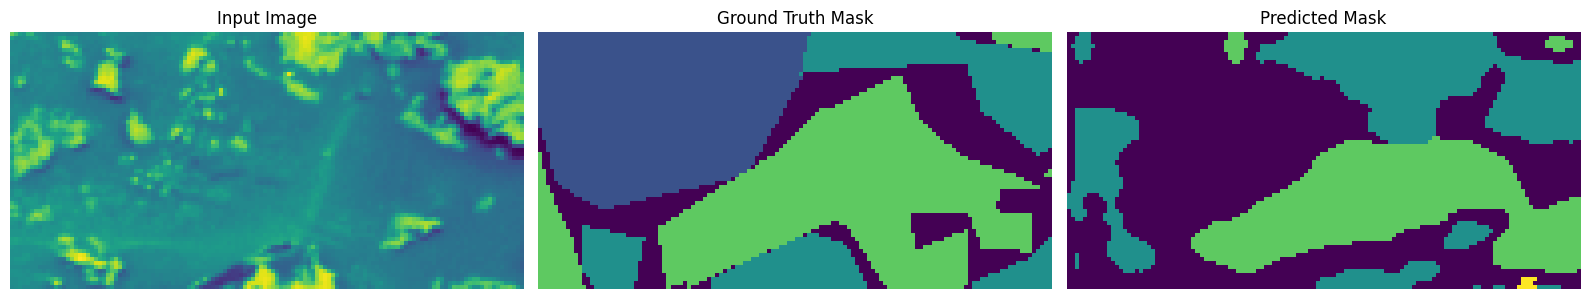

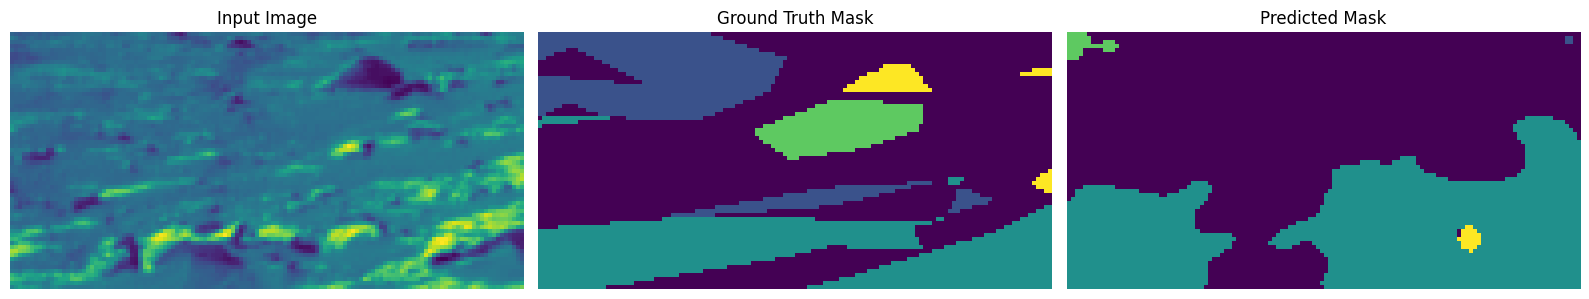

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 774ms/step - accuracy: 0.8412 - dice: 0.2591 - loss: 0.1070 - one_hot_mean_io_u: 0.6541 - val_accuracy: 0.7053 - val_dice: 0.3566 - val_loss: 1.0707 - val_one_hot_mean_io_u: 0.4000
Epoch 67/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8358 - dice: 0.2639 - loss: 0.1206 - one_hot_mean_io_u: 0.6319 - val_accuracy: 0.7348 - val_dice: 0.3233 - val_loss: 0.9514 - val_one_hot_mean_io_u: 0.4463
Epoch 68/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8510 - dice: 0.2476 - loss: 0.0991 - one_hot_mean_io_u: 0.6846 - val_accuracy: 0.6762 - val_dice: 0.3780 - val_loss: 0.9033 - val_one_hot_mean_io_u: 0.3885
Epoch 69/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8592 - dice: 0.2377 - loss: 0.0909 - one_hot_mean_io_u: 0.7069 - val_accuracy: 0.7008 - val_dice: 0.3691 - val_loss: 0.7481 - val_one_hot_mean_io_u: 0.4058
Epoch 70/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8711 - dice: 0.2275 - loss: 0.0837 - one_hot

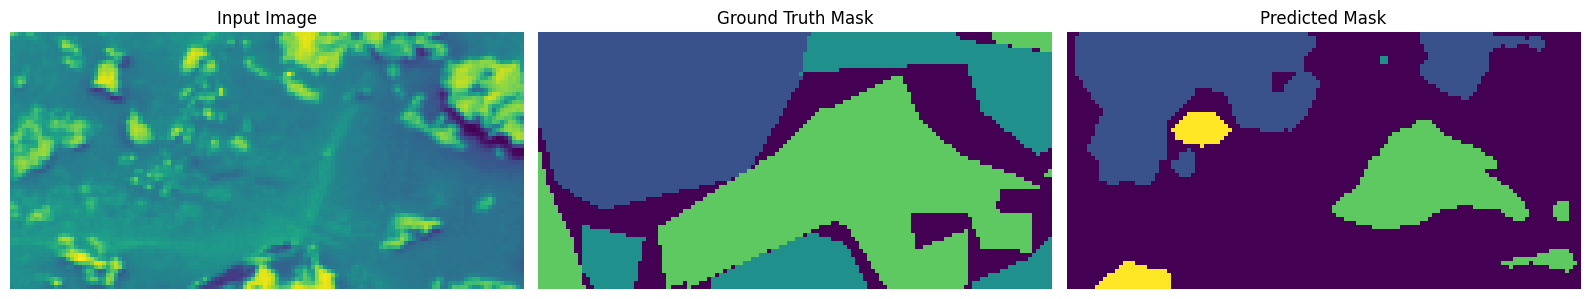

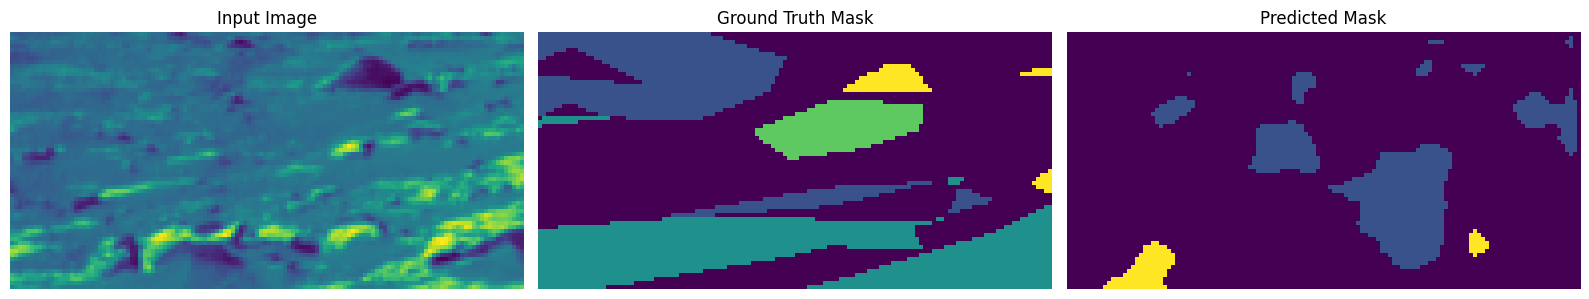

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 772ms/step - accuracy: 0.8739 - dice: 0.2256 - loss: 0.0793 - one_hot_mean_io_u: 0.6867 - val_accuracy: 0.5739 - val_dice: 0.4473 - val_loss: 1.8830 - val_one_hot_mean_io_u: 0.2676
Epoch 72/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8533 - dice: 0.2469 - loss: 0.1001 - one_hot_mean_io_u: 0.6491 - val_accuracy: 0.7211 - val_dice: 0.3426 - val_loss: 0.8670 - val_one_hot_mean_io_u: 0.4272
Epoch 73/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8767 - dice: 0.2239 - loss: 0.0794 - one_hot_mean_io_u: 0.6873 - val_accuracy: 0.6991 - val_dice: 0.3496 - val_loss: 0.8499 - val_one_hot_mean_io_u: 0.4001
Epoch 74/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.8741 - dice: 0.2247 - loss: 0.0868 - one_hot_mean_io_u: 0.6502 - val_accuracy: 0.4739 - val_dice: 0.5024 - val_loss: 1.7026 - val_one_hot_mean_io_u: 0.2030
Epoch 75/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.7405 - dice: 0.3566 - loss: 0.2573 - one_hot

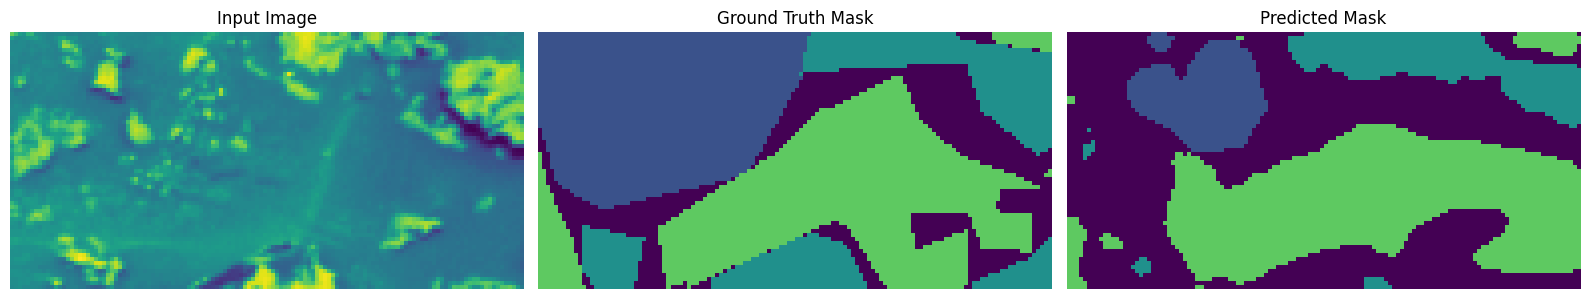

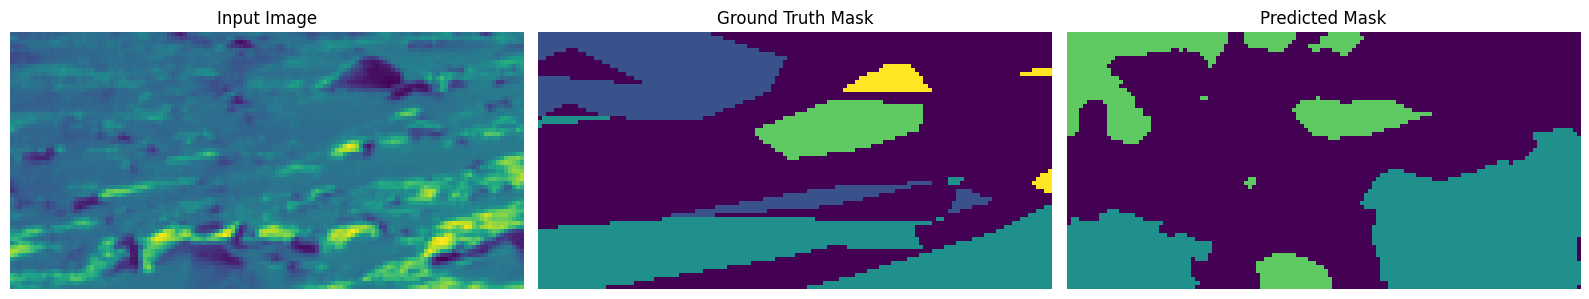

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 772ms/step - accuracy: 0.8229 - dice: 0.2798 - loss: 0.1367 - one_hot_mean_io_u: 0.5729 - val_accuracy: 0.6832 - val_dice: 0.3816 - val_loss: 0.8125 - val_one_hot_mean_io_u: 0.3907
Epoch 77/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 762ms/step - accuracy: 0.8598 - dice: 0.2369 - loss: 0.0933 - one_hot_mean_io_u: 0.6457 - val_accuracy: 0.7357 - val_dice: 0.3288 - val_loss: 0.7693 - val_one_hot_mean_io_u: 0.4339
Epoch 78/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 761ms/step - accuracy: 0.8776 - dice: 0.2195 - loss: 0.0786 - one_hot_mean_io_u: 0.6791 - val_accuracy: 0.7053 - val_dice: 0.3375 - val_loss: 0.9059 - val_one_hot_mean_io_u: 0.4132
Final validation Mean Intersection Over Union: 46.49%


In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping,viz_callback1,viz_callback2],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_one_hot_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_pre.keras'
model.save(model_filename)

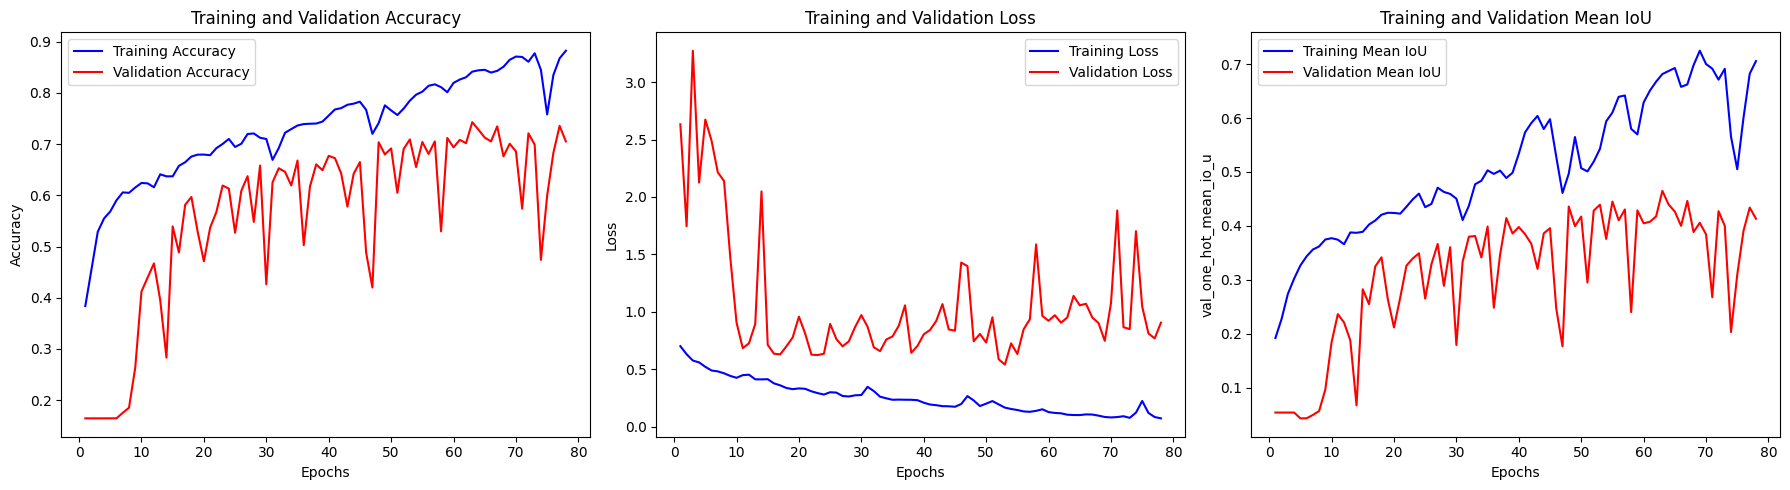

In [ ]:
# Extract metrics
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
mean_iou = history['one_hot_mean_io_u']
val_mean_iou = history['val_one_hot_mean_io_u']
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Mean IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, mean_iou, 'b-', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r-', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('val_one_hot_mean_io_u')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 90s 283ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    # Converts segmentation predictions into a DataFrame format for Kaggle.
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Get the current date and time as a string
current_time = time.strftime("%Y-%m-%d_%H:%M:%S")

# Create and download the csv submission file
submission_filename = f"unet3Crossentropy"+".csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)